In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-11-02 05:08:37--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.208.120, 54.231.171.8, 16.15.188.70, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.208.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.82MB/s    in 2.2s    

2025-11-02 05:08:40 (5.82 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
data = os.path.join("jena_climate_2009_2016.csv")

In [3]:
with open(data) as f:
    data = f.read()

In [4]:
records = data.split("\n")
title = records[0].split(",")
records = records[1:]
print(title)
print(len(records))
import os
data = os.path.join("jena_climate_2009_2016.csv")

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [5]:
with open(data) as f:
    data = f.read()

In [6]:
records = data.split("\n")
title = records[0].split(",")
records = records[1:]
print(title)
print(len(records))
#Processing and analyzing the data.


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [7]:
import numpy as np
temp = np.zeros((len(records),))
raw_data = np.zeros((len(records), len(title) - 1))
for i, line in enumerate(records):
    values = [float(x) for x in line.split(",")[1:]]
    temp[i] = values[1]
    raw_data[i, :] = values[:]
import numpy as np
temp = np.zeros((len(records),))
raw_data = np.zeros((len(records), len(title) - 1))
for i, line in enumerate(records):
    values = [float(x) for x in line.split(",")[1:]]
    temp[i] = values[1]
    raw_data[i, :] = values[:]
#Visualizing the temperature time series data.

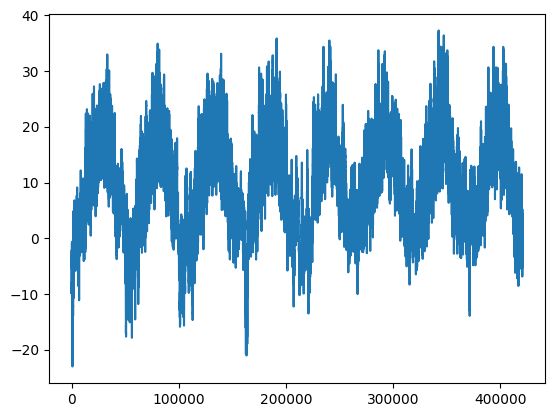

In [8]:
from matplotlib import pyplot as plt
plt.plot(range(len(temp)), temp)
#Visualizing the temperature time series for the first 10 days.

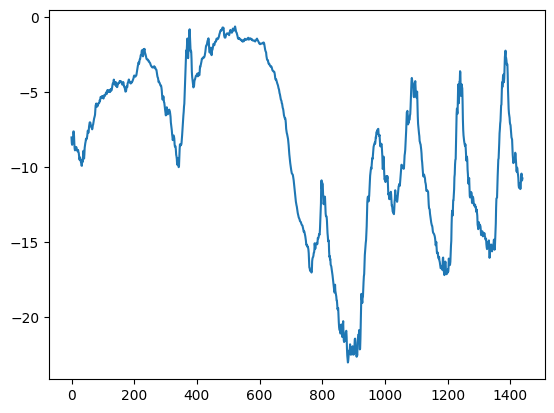

In [9]:
plt.plot(range(1440), temp[:1440])
#Calculating the number of samples for each data split.

In [10]:
train_Sample_Num = int(0.5 * len(raw_data))
val_raw_data = int(0.25 * len(raw_data))
test_Sample_Number = len(raw_data) - train_Sample_Num - val_raw_data
print("train_Sample_Num:", train_Sample_Num)
print("val_raw_data:", val_raw_data)
print("test_Sample_Number:", test_Sample_Number)
#Data Preparation
#Normalizing the data

train_Sample_Num: 210225
val_raw_data: 105112
test_Sample_Number: 105114


In [11]:
mean = raw_data[:train_Sample_Num].mean(axis=0)
raw_data -= mean
std = raw_data[:train_Sample_Num].std(axis=0)
raw_data /= std
import numpy as np
from tensorflow import keras
total_series = np.arange(10)
temp_dataset = keras.utils.timeseries_dataset_from_array(
    data=total_series[:-3],
    targets=total_series[3:],
    sequence_length=3,
    batch_size=2,
)

In [12]:
for inputs, targets in temp_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))
#Instantiating datasets for training, validation, and testing

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [13]:
sample_rate = 6
seq_len = 120
time_delay = sample_rate * (seq_len + 24 - 1)
batch_size = 256

In [14]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-time_delay],
    targets=temp[time_delay:],
    sampling_rate=sample_rate,
    sequence_length=seq_len,
    batch_size=batch_size
)


In [15]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-time_delay],
    targets=temp[time_delay:],
    sampling_rate=sample_rate,
    sequence_length=seq_len,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_Sample_Num,
    end_index=train_Sample_Num + val_raw_data)


In [16]:
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-time_delay],
    targets=temp[time_delay:],
    sampling_rate=sample_rate,
    sequence_length=seq_len,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_Sample_Num + val_raw_data)


In [17]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
#A common-sense, non-machine-learning baseline
#Computing the common-sense baseline MAE

samples shape: (256, 120, 14)
targets shape: (256,)


In [18]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [19]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")


Validation MAE: 2.44
Test MAE: 2.62


In [20]:
!pip install tensorflow==2.12

ERROR: Could not find a version that satisfies the requirement tensorflow==2.12 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12


In [21]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(seq_len, raw_data.shape[-1]))
x = layers.Reshape((seq_len * raw_data.shape[-1],))(inputs)  # explicit flatten
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

training_history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

#Visualizing the outcomes

Epoch 1/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 68s 40ms/step - loss: 24.0887 - mae: 3.7260 - val_loss: 38.1320 - val_mae: 4.8871
Epoch 2/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 66s 40ms/step - loss: 15.5277 - mae: 3.0100 - val_loss: 33.5132 - val_mae: 4.4006
Epoch 3/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 64s 39ms/step - loss: 13.2849 - mae: 2.7901 - val_loss: 25.8886 - val_mae: 3.8015
Epoch 4/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 64s 39ms/step - loss: 12.1667 - mae: 2.6689 - val_loss: 25.4082 - val_mae: 3.7934
Epoch 5/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 63s 38ms/step - loss: 11.4578 - mae: 2.5922 - val_loss: 26.0457 - val_mae: 3.8194
Epoch 6/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 64s 39ms/step - loss: 11.1464 - mae: 2.5578 - val_loss: 28.0398 - val_mae: 3.9251
Epoch 7/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 64s 39ms/step - loss: 10.9312 - mae: 2.5375 - val_loss: 25.1750 - val_mae: 3.7076
Epoch 8/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 66s 40ms/step - loss: 10.7842 - mae: 2.5193 - val_loss: 25.9780 - val_mae: 3.7554
Epoch 9/

Epoch 1/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - loss: 26.4799 - mae: 4.0386 - val_loss: 98.1900 - val_mae: 8.0059
Epoch 2/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 67s 41ms/step - loss: 22.0264 - mae: 3.6735 - val_loss: 133.1745 - val_mae: 9.3212
Epoch 3/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 67s 41ms/step - loss: 20.8452 - mae: 3.5695 - val_loss: 164.5275 - val_mae: 10.3564
Epoch 4/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 68s 41ms/step - loss: 19.0724 - mae: 3.3933 - val_loss: 158.4978 - val_mae: 10.1427
Epoch 5/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 70s 43ms/step - loss: 17.5241 - mae: 3.2365 - val_loss: 155.7553 - val_mae: 10.0559
Epoch 6/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 69s 42ms/step - loss: 16.5649 - mae: 3.1467 - val_loss: 143.6230 - val_mae: 9.7377
Epoch 7/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 68s 42ms/step - loss: 16.2503 - mae: 3.1153 - val_loss: 133.5534 - val_mae: 9.4167
Epoch 8/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 68s 42ms/step - loss: 16.0597 - mae: 3.0948 - val_loss: 126.3572 - val_mae: 9.174

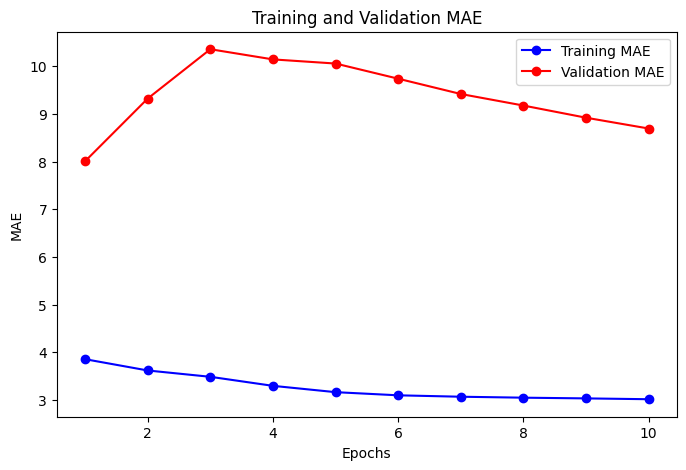

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

inputs = keras.Input(shape=(seq_len, raw_data.shape[-1]))

# 1D Convolutional layers
x = layers.Conv1D(16, 3, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(32, 3, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(32, 3, activation="relu")(x)

# Pool across time dimension
x = layers.GlobalAveragePooling1D()(x)

# Output layer
outputs = layers.Dense(1)(x)

# Build model
model = keras.Model(inputs, outputs)

# Compile model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv1d.keras", save_best_only=True)
]

training_history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_conv1d.keras")
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

loss = training_history.history["mae"]
val_loss = training_history.history["val_mae"]
epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss, "bo-", label="Training MAE")
plt.plot(epochs_range, val_loss, "ro-", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


In [23]:
# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "jena_conv.keras",
        save_best_only=True
    )
]

# Compile model
model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

# Train the model
training_history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)



Epoch 1/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 71s 42ms/step - loss: 21.9891 - mae: 3.6731 - val_loss: 131.9159 - val_mae: 9.2687
Epoch 2/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 67s 41ms/step - loss: 20.8223 - mae: 3.5679 - val_loss: 169.8814 - val_mae: 10.4950
Epoch 3/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 69s 42ms/step - loss: 19.1808 - mae: 3.4054 - val_loss: 156.8049 - val_mae: 10.0718
Epoch 4/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 68s 42ms/step - loss: 17.4953 - mae: 3.2345 - val_loss: 147.3584 - val_mae: 9.7863
Epoch 5/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 69s 42ms/step - loss: 16.5281 - mae: 3.1446 - val_loss: 134.6472 - val_mae: 9.4349
Epoch 6/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 68s 42ms/step - loss: 16.2339 - mae: 3.1125 - val_loss: 126.8018 - val_mae: 9.1925
Epoch 7/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 67s 41ms/step - loss: 15.9447 - mae: 3.0852 - val_loss: 122.7072 - val_mae: 9.0611
Epoch 8/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 68s 41ms/step - loss: 15.7445 - mae: 3.0648 - val_loss: 115.8977 - val_mae: 8.782

In [24]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#Establishing an initial recurrent model as a baseline.
#A simple LSTM-based model

405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 113.5215 - mae: 8.3432
Test MAE: 8.37


In [25]:
inputs = keras.Input(shape=(seq_len, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [26]:
# Callback to save best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "jena_lstm.keras",
        save_best_only=True
    )
]

# Compile model
model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

# Train the model
training_history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)


Epoch 1/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 78s 47ms/step - loss: 67.1785 - mae: 6.2623 - val_loss: 16.8832 - val_mae: 3.0703
Epoch 2/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 74s 45ms/step - loss: 17.9393 - mae: 3.1481 - val_loss: 11.6260 - val_mae: 2.6227
Epoch 3/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 75s 46ms/step - loss: 14.3552 - mae: 2.8319 - val_loss: 10.8746 - val_mae: 2.5783
Epoch 4/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 75s 46ms/step - loss: 12.9655 - mae: 2.7143 - val_loss: 10.7531 - val_mae: 2.5785
Epoch 5/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 74s 45ms/step - loss: 12.1959 - mae: 2.6509 - val_loss: 10.4559 - val_mae: 2.5394
Epoch 6/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 76s 46ms/step - loss: 11.6835 - mae: 2.6049 - val_loss: 10.3849 - val_mae: 2.5305
Epoch 7/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 74s 45ms/step - loss: 11.3546 - mae: 2.5740 - val_loss: 10.1093 - val_mae: 2.4933
Epoch 8/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 75s 46ms/step - loss: 11.0526 - mae: 2.5463 - val_loss: 9.9330 - val_mae: 2.4676
Epoch 9/1

In [27]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#Understanding recurrent neural networks
#NumPy implementation of a simple RNN

405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - loss: 10.7830 - mae: 2.5551
Test MAE: 2.56


In [28]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output = np.stack(successive_outputs, axis=0)
#A recurrent layer in Keras
#An RNN layer that can process sequences of any length

In [29]:
total_features = 14
inputs = keras.Input(shape=(None, total_features))
outputs = layers.SimpleRNN(16)(inputs)
#An RNN layer that returns only its last output step

In [30]:
total_features = 14
steps = 120
inputs = keras.Input(shape=(steps, total_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)
#An RNN layer that returns its full output sequence

(None, 16)


In [31]:
total_features = 14
steps = 120
inputs = keras.Input(shape=(steps, total_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)
#Stacking RNN layers

(None, 120, 16)


In [32]:
inputs = keras.Input(shape=(steps, total_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
#Exploring advanced techniques with recurrent neural networks
#Applying recurrent dropout to combat overfitting
#Training and assessing an LSTM model with dropout regularization

In [33]:
inputs = keras.Input(shape=(seq_len, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
training_history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
inputs = keras.Input(shape=(seq_len, total_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

Epoch 1/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 570s 346ms/step - loss: 46.1643 - mae: 5.0962 - val_loss: 15.2105 - val_mae: 3.0655
Epoch 2/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 567s 347ms/step - loss: 18.5286 - mae: 3.2780 - val_loss: 13.4715 - val_mae: 2.9030
Epoch 3/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 569s 348ms/step - loss: 16.9040 - mae: 3.1378 - val_loss: 13.2625 - val_mae: 2.8771
Epoch 4/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 567s 346ms/step - loss: 16.1943 - mae: 3.0772 - val_loss: 12.8629 - val_mae: 2.8314
Epoch 5/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 564s 345ms/step - loss: 15.8039 - mae: 3.0407 - val_loss: 12.5780 - val_mae: 2.7924
Epoch 6/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 567s 346ms/step - loss: 15.4541 - mae: 3.0109 - val_loss: 12.1916 - val_mae: 2.7449
Epoch 7/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 568s 347ms/step - loss: 15.2255 - mae: 2.9870 - val_loss: 12.0333 - val_mae: 2.7236
Epoch 8/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 566s 346ms/step - loss: 15.0485 - mae: 2.9731 - val_loss: 11.8563 - val_mae:

In [35]:
inputs = keras.Input(shape=(seq_len, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)